In [1]:
import numpy as np
import json
from pprint import pprint

from collections import defaultdict
import operator

import matplotlib.pyplot as plt; plt.rcdefaults()


import seaborn as sns

import sys
sys.path.append('/projects2/refer360test/src')
import os
from tqdm import tqdm
from utils import rad2degree
from utils import coord_gaussian
from panoramic_camera import PanoramicCamera as camera


In /home/vcirik/bin/anaconda2/envs/refer360sim/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vcirik/bin/anaconda2/envs/refer360sim/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vcirik/bin/anaconda2/envs/refer360sim/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/vcirik/bin/anaconda2/envs/refer360sim/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed tw

In [2]:
def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    #IPython.display.display(i)

In [3]:
data = json.load(open('../../data/train.json'))

In [4]:
print(data[0])

{'date': '2019-10-01T17:59:29.542016Z', 'refexp': "|||turn until you're facing the counter that has the word daygum on it's display.|||behind the display, on the wall, you'll see a painted sun.|||waldo is on the left side of the sun's circle.", 'turkerid': 'A1QA5EWFMNKGTA', 'imageurl': 'https://s3.amazonaws.com/refer360/sun360images_4552x2276/pano_apqqbmmivfquan_restaurant.jpg', 'follow_count': 1, 'annotationid': 4395, 'longitude': 0.1661545689364925, 'feedback_text': 'kwyPXEEwJQqwtbGyTkxprewRlMgboFBsYUasIaYFGBNXJtRERT', 'session': 's03', 'actions': [{'pred_longitude': 0.1723856568506029, 'pred_latitude': 4.173017418895537, 'turkerid': 'A1F1BIPJR11LSR', 'annotationid': 4395, 'action_list': '|5.347537267283694,-0.6130369722905904|2.8235364129235627,1.0621791033255708|3.271213366060109,0.6066481685550511|4.0448305570065965,0.02152653682395167|5.183657893932898,-0.28477874690105454|0.2906273359667929,-0.44185837958054597|1.511921480049825,-0.34761059997285404|2.5211581200155457,-0.1473340

In [5]:
act_instances = {}
for instance in data:
  for action in instance['actions']:
    action['gt_latitude'] = instance['latitude']
    action['gt_longitude'] = instance['longitude']
    action['imageurl'] = instance['imageurl']
    
    act_instances[action['actionid']] = action

In [6]:
width = 4552
height = 2276
canvas = np.zeros((height,width))

pbar = tqdm(act_instances)
size = 2
min_x, min_y, max_x, max_y = width, height, 0, 0

canvases = {}
transition = {}
transitions = ['3->4', '2->3','1->2','0->1'][::-1]
transition_all = list()
for ii,t in enumerate(transitions):
  transition[t] = list()
  canvases[ii] = np.zeros((height,width))
canvases[len(transitions)] = np.zeros((height,width))

for kk,act_id in enumerate(pbar):
  
  instance = act_instances[act_id]
  for step, fovs in enumerate(instance['action_list'].split('_')):
    
    first_x, first_y = -1,-1
    for jj,fov in enumerate(fovs.split('|')[1:]):
      center = fov.split(',')
      center_lat, center_lng = float(center[0]), float(center[1])
      
      center_latitude, center_longitude  = rad2degree(center_lat, center_lng, adjust = False)
      
      gt_x = int(width * ((center_latitude)/360.0))
      gt_y = int(height - height * ((center_longitude + 90)/180.0))
      canvas[gt_y-size:gt_y+size,gt_x-size:gt_x+size] = 1.0

      if first_x == -1 and first_y == -1:
        first_x, first_y = gt_x, gt_y
    canvases[step][gt_y-size:gt_y+size,gt_x-size:gt_x+size] = 1.0       
    if step >= 1:
      transition['{}->{}'.format(step-1,step)].append((prev_x - first_x,prev_y - first_y))
      transition_all.append((prev_x - first_x,prev_y - first_y))
      max_x = max(max_x,(first_x - prev_x))
      max_y = max(max_y,(first_y - prev_y))
      
      min_x = min(min_x,(first_x - prev_x))
      min_y = min(min_y,(first_y - prev_y))

    prev_x, prev_y = first_x, first_y
pbar.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 12970/12970 [00:02<00:00, 5747.35it/s]


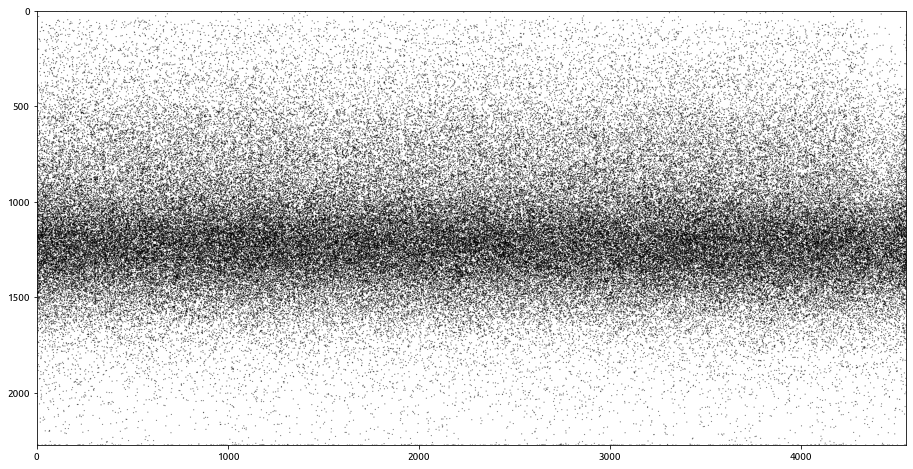

In [7]:
fig, ax = plt.subplots(figsize=(16,8))

sns.set_style("white")
sns.set_style({'font.family': 'sans-serif',
               'font.sans-serif': 'Ubuntu',
              'font_scale' : 5})

inverted = np.ones(canvas.shape) - canvas
imgplot = plt.imshow(inverted, cmap='gray')

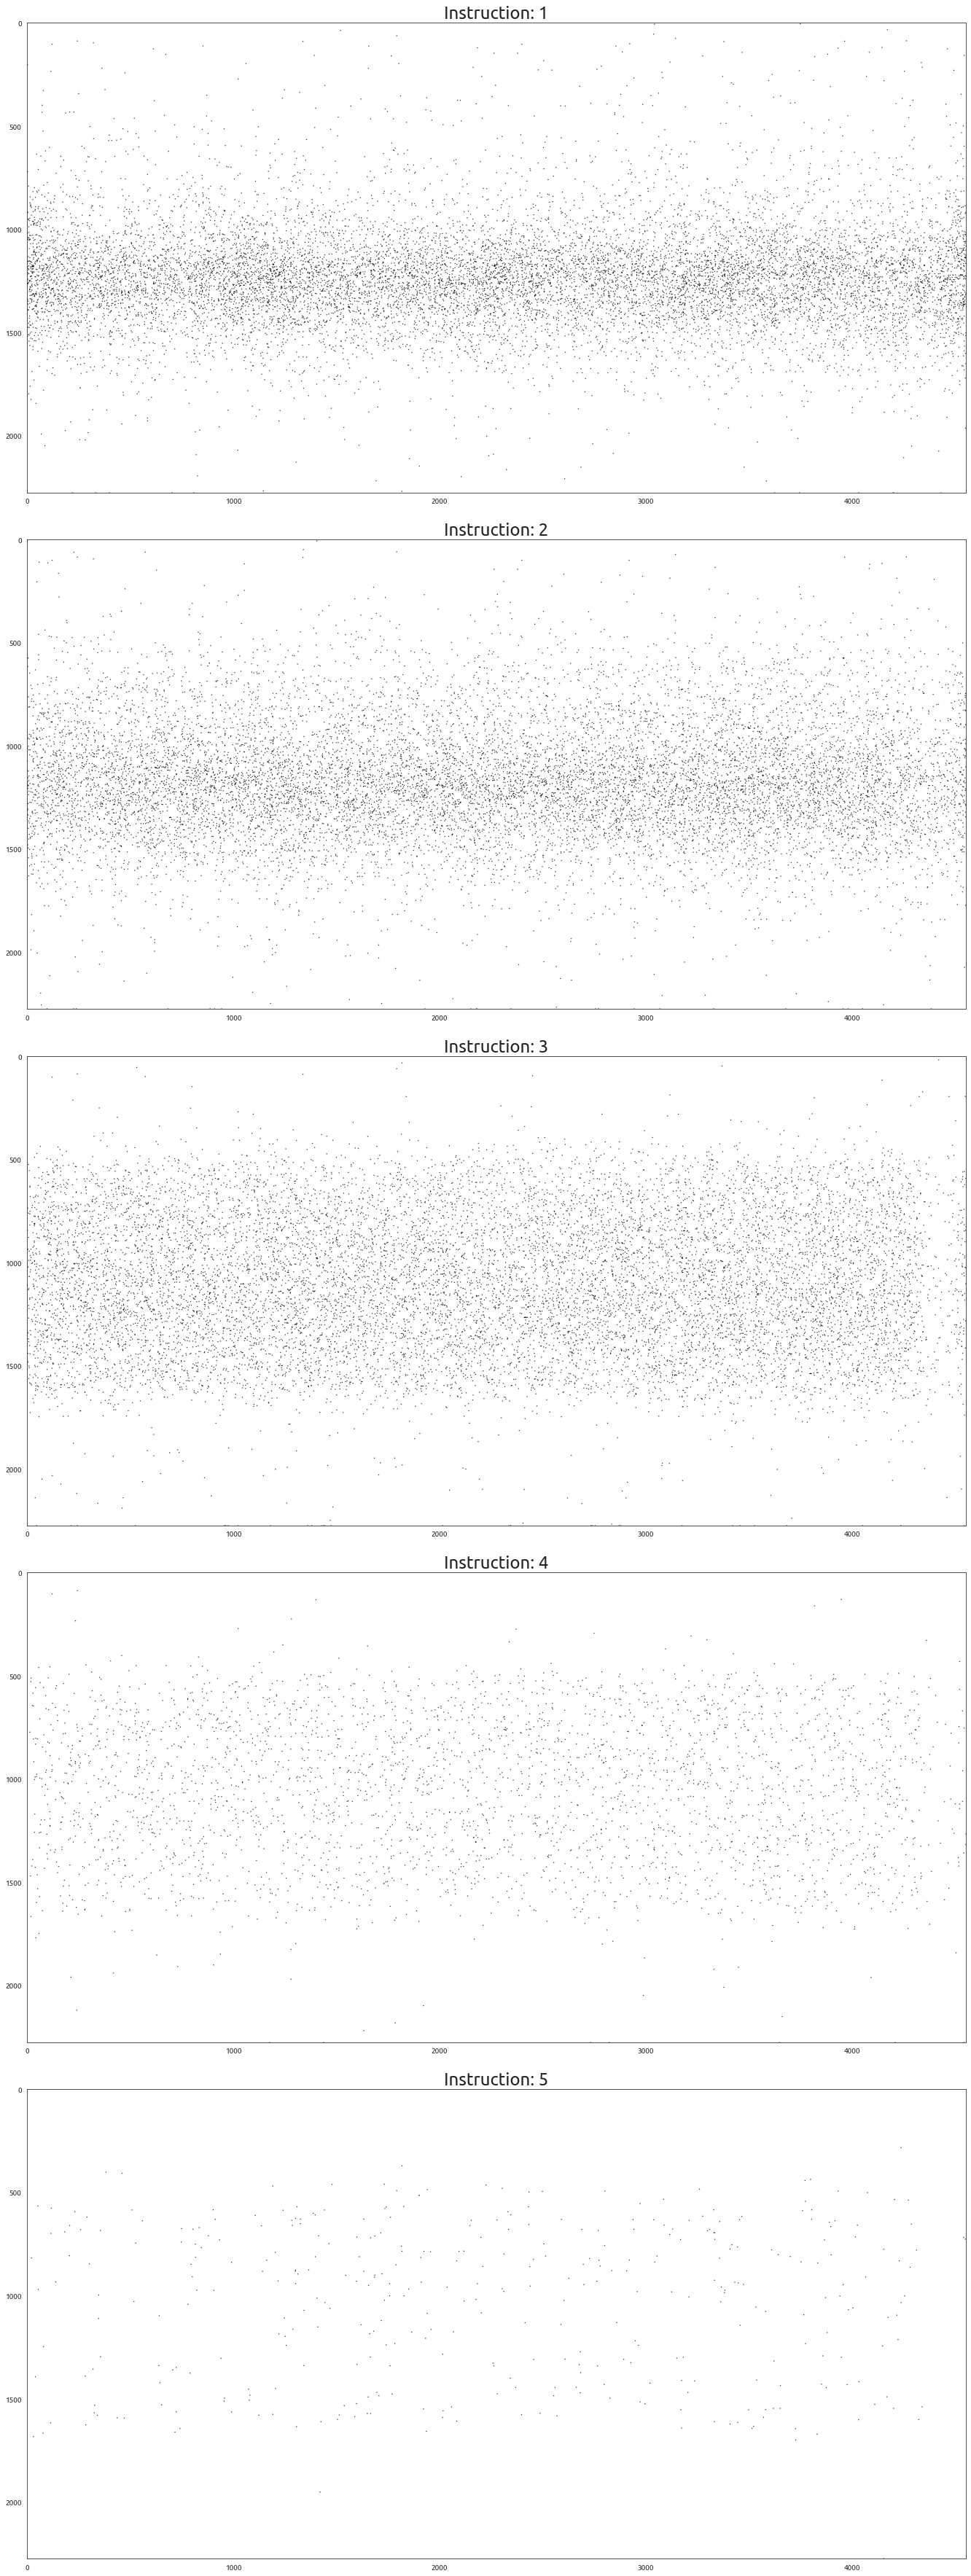

In [8]:
nrow = len(canvases)
ncols = 1

fig, axs = plt.subplots(nrows=nrow, ncols=ncols, figsize=(32,64))
fig.subplots_adjust(hspace = 0.1 ) 

FONTSIZE=24

ii = -1
for kk,c in enumerate(canvases.keys()):
  canvas = canvases[c]
  inverted = np.ones(canvas.shape) - canvas
  axs[kk].imshow(inverted, cmap='gray')
  axs[kk].set_title('Instruction: {}'.format(c+1), fontsize=FONTSIZE)
plt.rc('xtick',labelsize=FONTSIZE)
plt.rc('ytick',labelsize=FONTSIZE)
plt.show()


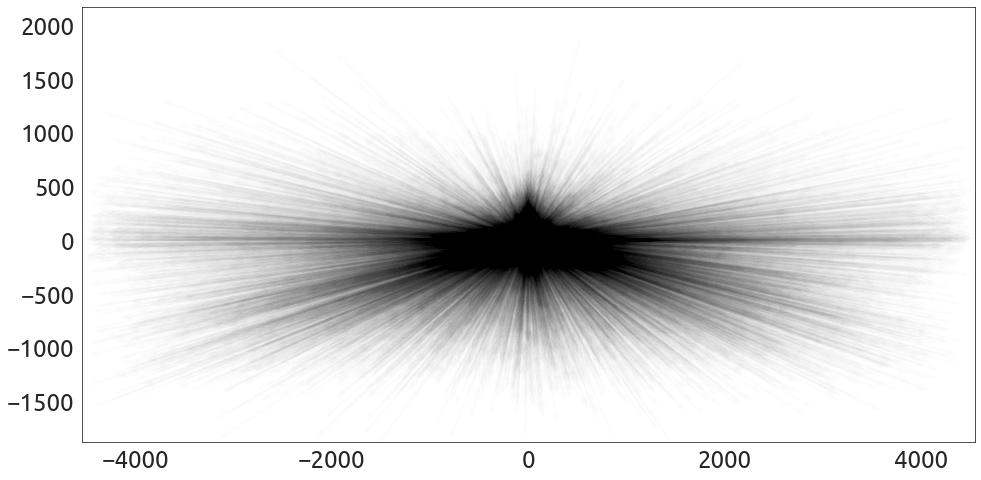

In [9]:
fig, ax = plt.subplots(figsize=(16,8))


X = []
Y = []
U = []
V = []
for t in transition_all:
  X.append(0)
  Y.append(0)
  U.append(t[0])
  V.append(t[1])

q = plt.quiver(X,Y,U,V, angles='xy', scale_units='xy', scale=1, alpha=0.01)
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)

#ax.quiverkey(q, X=0.1, Y=0.1, U=0.1,label='Quiver key, length = 10', labelpos='E')

plt.show()

0->1 12965 12965
1->2 12945 12945
2->3 3303 3303
3->4 379 379


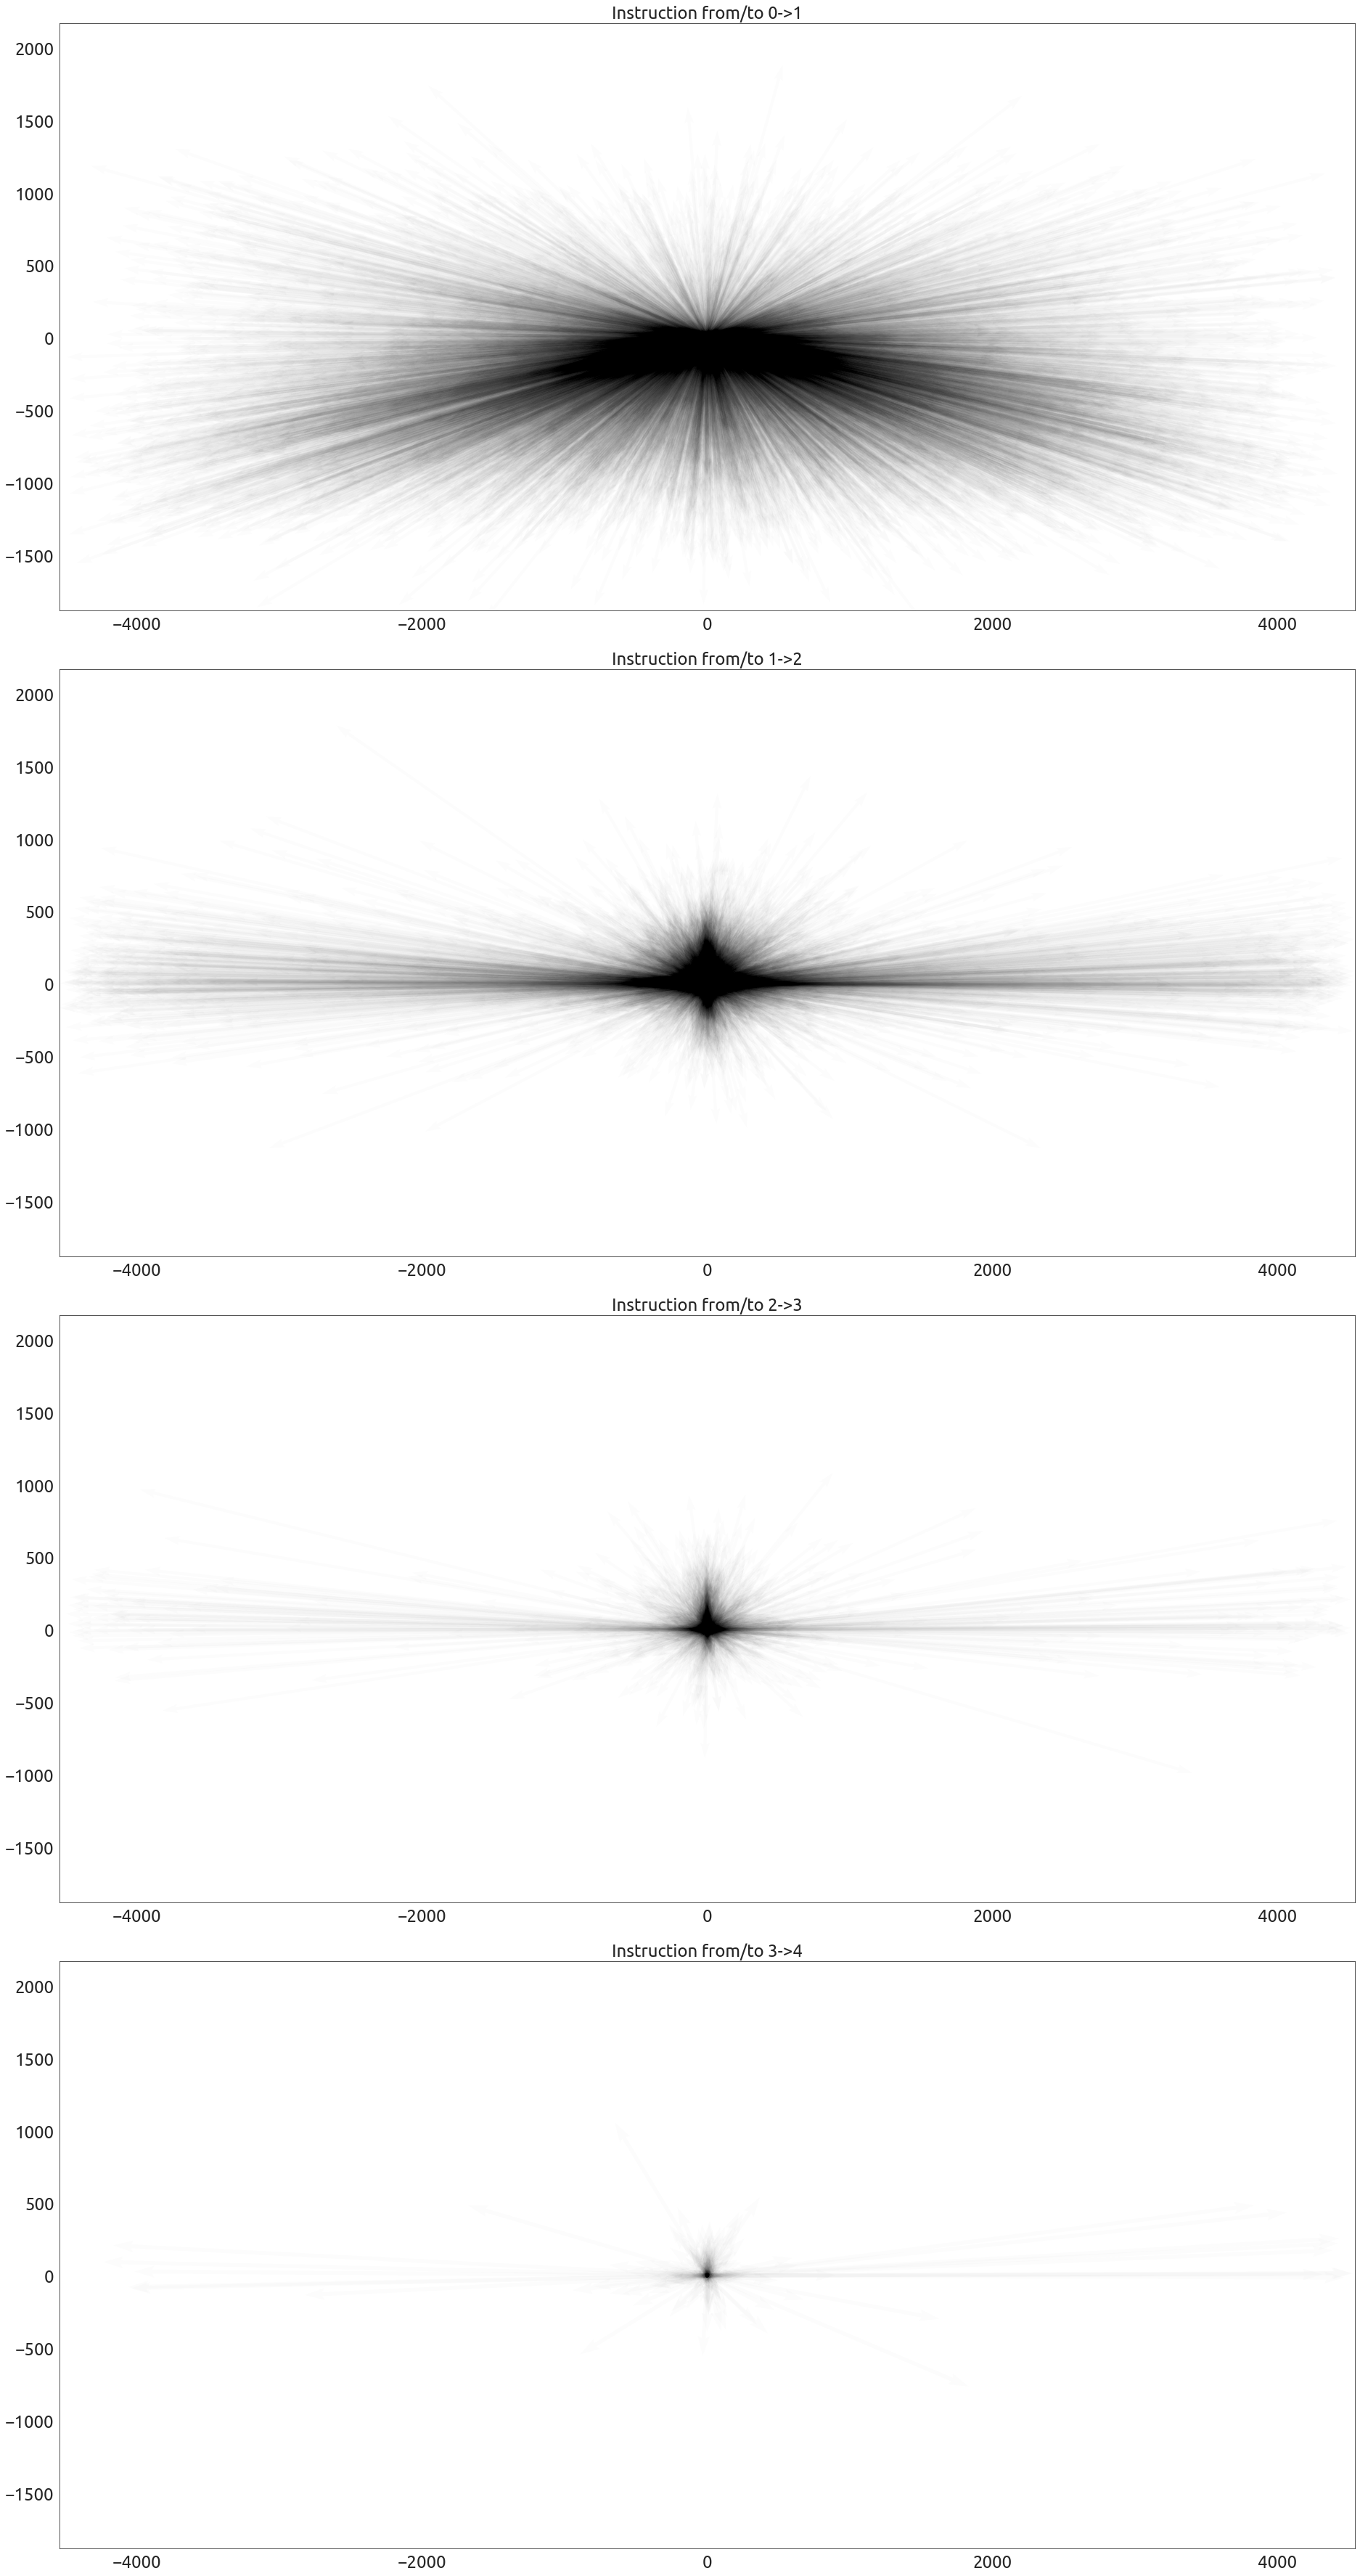

In [10]:
nrow = len(transition.keys())
ncols = 1

fig, axs = plt.subplots(nrows=nrow, ncols=ncols, figsize=(32,64))
fig.subplots_adjust(hspace = 0.1 ) 

FONTSIZE=24

ii = -1
for kk,t in enumerate(transition.keys()):
  tr = transition[t]
 
  X = []
  Y = []
  U = []
  V = []

  for tcoor in tr:
    X.append(0)
    Y.append(0)
    U.append(tcoor[0])
    V.append(tcoor[1])

  axs[kk].quiver(X,Y,U,V, angles='xy', scale_units='xy', scale=1, alpha=0.01)
  axs[kk].set_title('Instruction from/to {}'.format(t), fontsize=FONTSIZE)
  axs[kk].set_xlim(min_x, max_x)
  axs[kk].set_ylim(min_y, max_y)
  print(t,len(tr),len(X))
plt.rc('xtick',labelsize=FONTSIZE)
plt.rc('ytick',labelsize=FONTSIZE)

plt.show()